## Анализ временных рядов


В данной задаче вы будете работать с данными температуре воздуха. Таблица содержит данные погоды примерно за 5 лет для городов США, Канады и Израиля. 
Файл `temperature.csv` содержит температуру в градусах Кельвина.




In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

Загрузите таблицу. Обратиет внимание на параметр `parse_dates`, он используется для приведения столбца с датами к правильному типу данных.

In [2]:
df = pd.read_csv('temperature.csv', parse_dates=['datetime'])


Установим дату как индекс

In [3]:
df = df.set_index('datetime')
df.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,284.607306,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


Посмотрим, как выглядят наши данные.

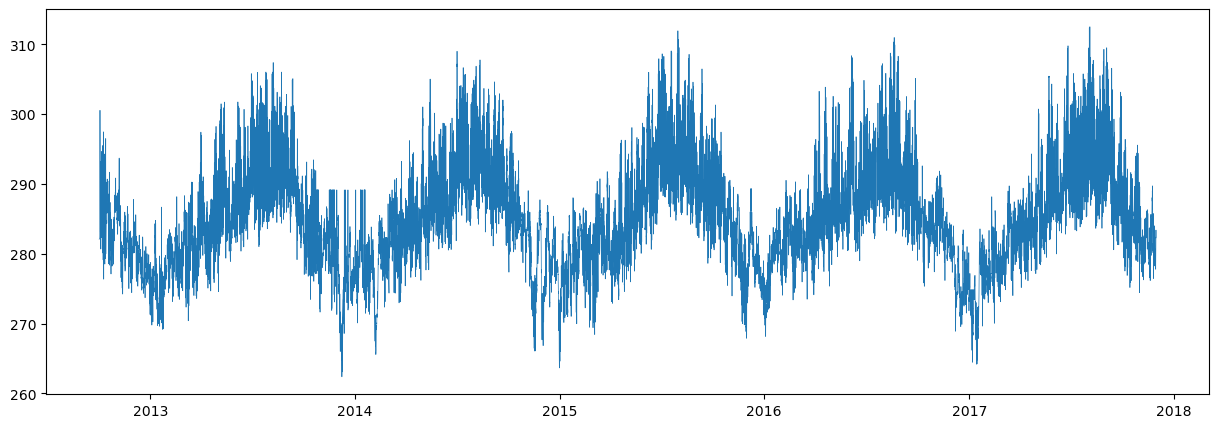

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['Portland'], lw=0.5);

Какие закономерности вы видите на графике?

**Ответ:** Годичная периодичность, что логично для температуры

Посчитайте пропуски для каждого из городов.

In [22]:
df['Vancouver'].isnull().sum()

795

In [24]:
for city in df.columns:
    print(city, ': ', df[city].isnull().sum())

Vancouver :  795
Portland :  1
San Francisco :  793
Seattle :  3
Los Angeles :  3
San Diego :  1
Las Vegas :  1
Phoenix :  3
Albuquerque :  1
Denver :  1
San Antonio :  1
Dallas :  4
Houston :  3
Kansas City :  1
Minneapolis :  13
Saint Louis :  1
Chicago :  3
Nashville :  2
Indianapolis :  7
Atlanta :  6
Detroit :  1
Jacksonville :  1
Charlotte :  3
Miami :  805
Pittsburgh :  3
Toronto :  1
Philadelphia :  3
New York :  793
Montreal :  3
Boston :  3
Beersheba :  798
Tel Aviv District :  793
Eilat :  792
Haifa :  798
Nahariyya :  797
Jerusalem :  793


Выберите город с наименьшим количеством пропусков. Назовем этот город X.

In [25]:
X = 'Portland'

Если данные имеют пропуски в начале или в конце, то лучше обрезать данные. Остальные пропуски стоит заполнить предыдущим значением по дате. Для этого вам может помочь функция `pandas.DataFrame.fillna`.

In [29]:
sample = df[X].fillna(method = 'backfill')

Для города X будем предсказывать температуру с помощью моделей машинного обучения.


Разбейте данные на обучение и тест. Для тестовой выборки используйте последние **365 дней** из данных (не забывайте, что в данных представлены показатели за каждый час).


In [30]:
test_size = 365*24
train = sample.iloc[:-test_size]
test = sample.iloc[-test_size:]

С форматом даты модели работать не умеют, поэтому нам необходимо описать дату признаками. Сделаем преобразование даты в признаки. 

In [31]:
def create_date_features(date):
    """Создает фичи из даты"""
    row = {}
    row["dayofweek"] = date.dayofweek 
    row["quarter"] = date.quarter 
    row["month"] = date.month 
    row["year"] = date.year 
    row["dayofyear"] = date.dayofyear 
    row["dayofmonth"] = date.day 
    row["weekofyear"] = date.weekofyear 
    return row

def create_only_date_train_features(y_series): 
    """
    Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    time_features = pd.DataFrame(
    [create_date_features(date) for date in y_series.index] )
    return time_features, y_series

In [32]:
X_train, y_train = create_only_date_train_features(train)
X_test, y_test = create_only_date_train_features(test)

In [39]:
X_train
y_train

datetime
2012-10-01 12:00:00    282.080000
2012-10-01 13:00:00    282.080000
2012-10-01 14:00:00    282.083252
2012-10-01 15:00:00    282.091866
2012-10-01 16:00:00    282.100481
                          ...    
2016-11-29 20:00:00    282.430000
2016-11-29 21:00:00    282.410000
2016-11-29 22:00:00    283.120000
2016-11-29 23:00:00    283.970000
2016-11-30 00:00:00    284.150000
Name: Portland, Length: 36493, dtype: float64

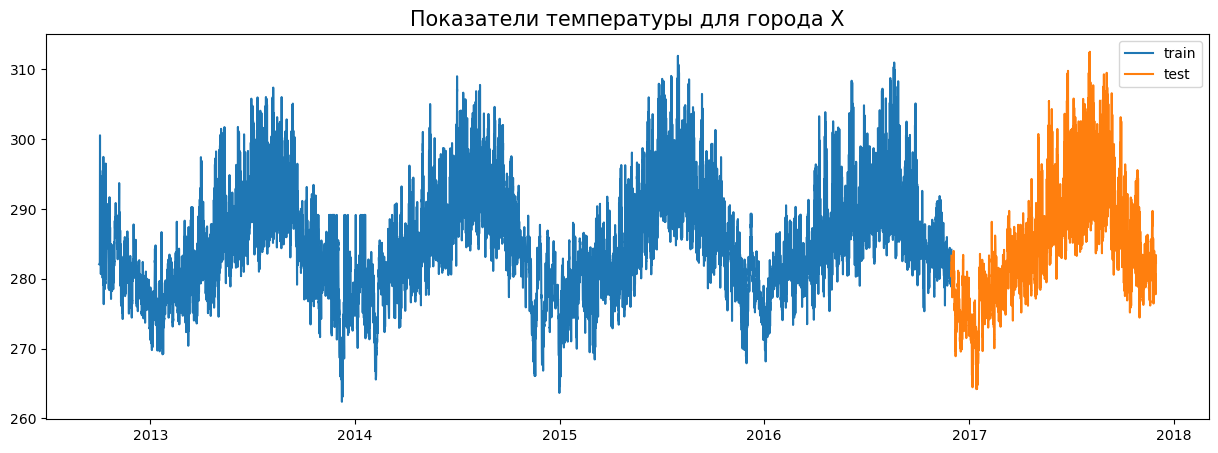

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.title("Показатели температуры для города Х", fontsize=15) 
plt.legend();

Постройте и обучите три модели: 
* модель линейной регрессии 
* решающего дерева
* случайного леса.

In [51]:
model = LinearRegression()
model.fit(X_train,y_train)
lin_predict = model.predict(X_test)

In [50]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)
tree_predict = clf.predict(X_test);

In [48]:
clf2 = RandomForestRegressor(random_state=42, n_estimators = 500)
clf2.fit(X_train, y_train)
forest_predict = clf2.predict(X_test);

Посчитайте качество на тесте (MSE, MAE, MAPE).



In [56]:
print('lin reg: ', mean_absolute_percentage_error(y_test, lin_predict).round(4))
print('tree: ', mean_absolute_percentage_error(y_test, tree_predict).round(4))
print('forest: ',mean_absolute_percentage_error(y_test, forest_predict).round(4))

lin reg:  0.024
tree:  0.016
forest:  0.0151


Визуализируйте результат.

In [57]:
def plot_results(y_to_train, y_to_test, y_forecast): 
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
        - y_to_train: pd.Series
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series
            Временной ряд, который предсказывает модель.
        - y_forecast: array
            Предсказания модели.
        - plot_conf_int: bool
            Надо ли строить предсказательного интервал.
        - left_bound: array
            Левая граница предсказательного интервала.
        - right_bound: array
            Правая граница предсказательного интервала.
    """
    plt.figure(figsize=(15, 5))
    plt.title("Показатели температуры для города Х", fontsize=15) 
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction") 
    plt.legend()
    plt.show()

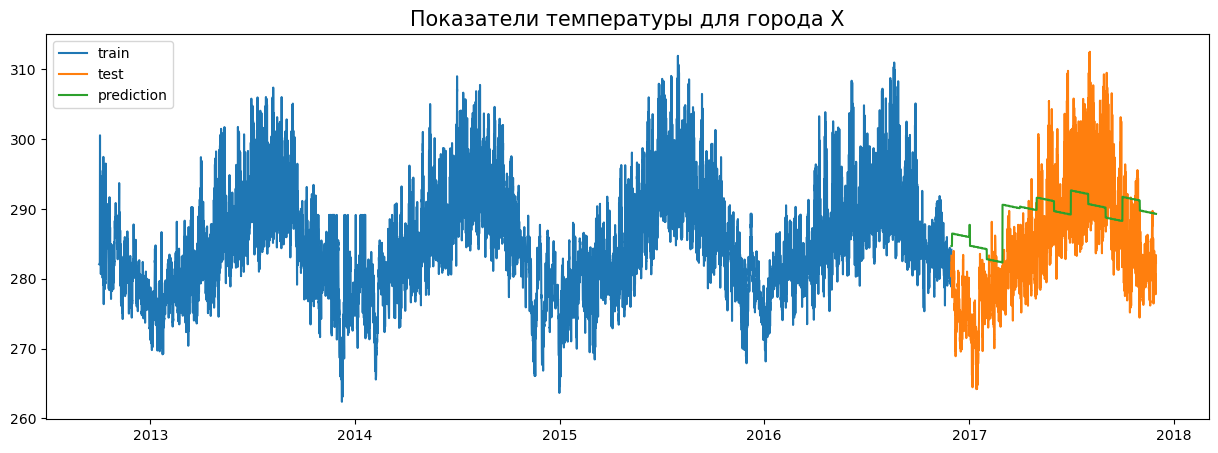

In [58]:
plot_results(y_train, y_test, lin_predict)

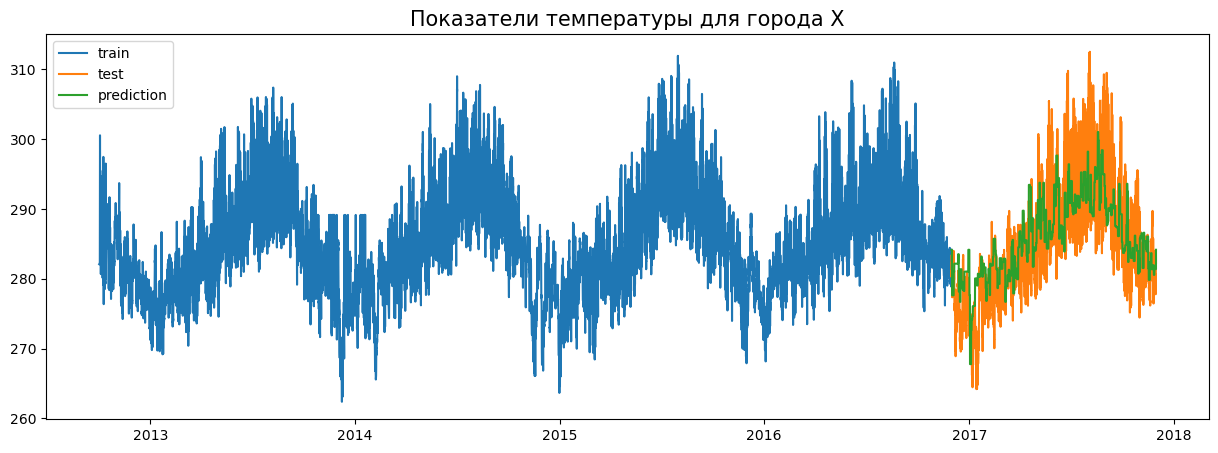

In [60]:
plot_results(y_train, y_test, tree_predict)

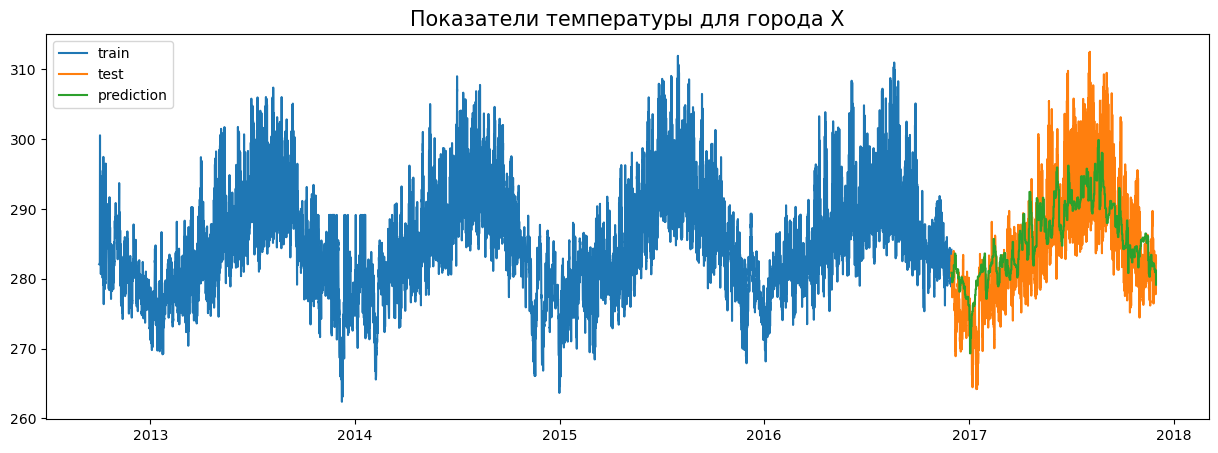

In [61]:
plot_results(y_train, y_test, forest_predict)

Сделайте выводы.

**Вывод:** Лес даёт наибольшую точность на тестовой выборке, а линейная регрессия - худший, что логично